In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import pickle
import os

from amftrack.util.sys import (

    update_plate_info,

    get_current_folders,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle
import scipy.io as sio
import networkx as nx
import numpy as np
from sthype import SpatialGraph, HyperGraph
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs

import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
import pandas as pd
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_all_edges,
    get_all_nodes, get_timedelta_second,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.temporal_graph_util import *
mpl.rcParams["figure.dpi"] = 100
import seaborn as sns
plt.style.use('presentation.mplstyle')
import logging

# Get the logger for 'fontTools'
font_tools_logger = logging.getLogger('fontTools')

# Set the logging level to WARNING, which ignores DEBUG and INFO messages
font_tools_logger.setLevel(logging.WARNING)

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


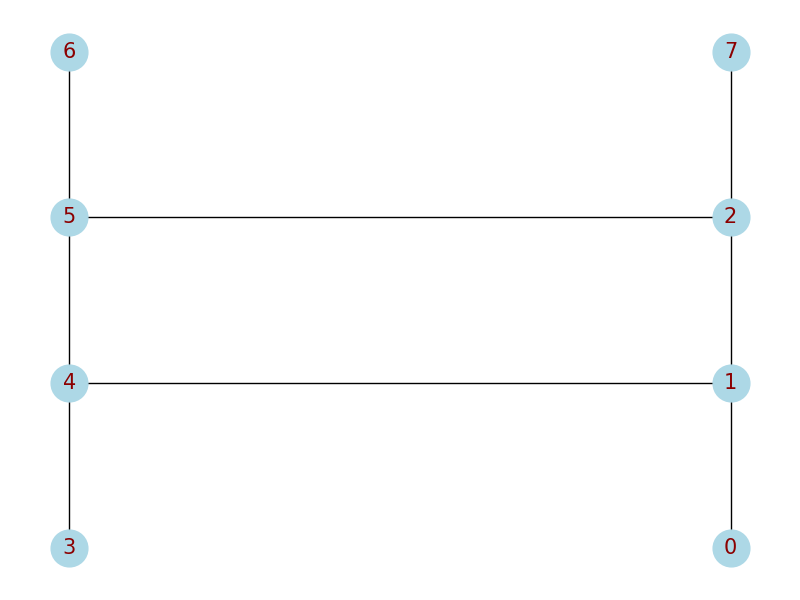

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

# Create an empty graph
G = nx.Graph()

# Add 6 nodes
G.add_nodes_from(range(8))

# Manually set positions for a 3x2 lattice
positions = {0: (1, 0), 1: (1, 1), 2: (1, 2),
             3: (0, 0), 4: (0, 1), 5: (0, 2),6:(0,3),7:(1,3)}

# Add edges between adjacent nodes
edges = [(0, 1), (1, 2),  # edges in the top row
         (3, 4), (4, 5),  # edges in the bottom row
        (1, 4),(5,6),(2,7),(2,5)]  # vertical edges connecting rows

# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph with labels and specified node positions
nx.draw(G, pos=positions, with_labels=True, node_color='lightblue', node_size=700, font_size=15, font_color='darkred')
plt.show()


In [62]:
nodes_sink = [6,7]
nodes_source = [3,0]
ext_flows_out = {6 : 1, 7 : 1}
ext_flows_in = {3 : -0.2, 0:-1.8}


for edge in G.edges:
    G[edge[0]][edge[1]]["radius"] = 3
    G[edge[0]][edge[1]]["length"] = 1

    G[edge[0]][edge[1]]['v0'] = 0

DG = convert_to_directed(G)
for node in nodes_sink:
    ext_flows_in[node] = 0
# for node in nodes_source:
#     DG.add_edge(node, "ground", length=0, radius=2, v0=0, Res=0, pot=0)  # Add edge back to the root

tot_flow = np.sum(list(ext_flows_in.values()))
ext_flows = {**ext_flows_in, **ext_flows_out}
print("net_flow",np.sum(list(ext_flows.values())))
A, b = build_matrix_system(DG, ext_flows)
flows = solve_flows(A, b)
edge_flows = {edge: flow for edge, flow in zip(DG.edges(), flows)}
nx.set_edge_attributes(G, edge_flows, "water_flux_heaton")
for edge in G.edges:
    G[edge[0]][edge[1]]["water_flux_heaton_abs"] = abs(G[edge[0]][edge[1]]["water_flux_heaton"])
    G[edge[0]][edge[1]]["speed_heaton"] = G[edge[0]][edge[1]]["water_flux_heaton"] / (np.pi * G[edge[0]][edge[1]]["radius"] ** 2)

net_flow 0.0
found all cycles


Processing Cycles: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


In [63]:
def convert_to_directed2(undirected_graph,attribute):
    # Create a new directed graph
    directed_graph = nx.DiGraph()

    # Define constant values for dynamic viscosity (mu)
    mu = 1e-3  #kg.m-1.s-1
    mu = mu * 1e-6 #kg.um-1.s-1 (but doesn't really have consequences
    # until compared with aquaporin porosity)

    # Add edges to the directed graph with direction based on node label ordering
    for u, v, attr in undirected_graph.edges(data=True):
        direction = (2*(u<v)-1)*(2*(attr[attribute]>0)-1)
        if direction==1:
            directed_graph.add_edge(u, v, **attr)
        else:
            directed_graph.add_edge(v, u, **attr)

    # Calculate the resistance and potential for each edge in the directed graph
    for u, v, attr in directed_graph.edges(data=True):
        # attr['radius'] = max(attr['width'] / 2, 0.5)
        # attr['v0'] = np.sign(attr['QBC_net'])*3 if abs(attr['QBC_net'])>0 else 0
        attr['Res'] = 8 * mu * attr["length"] / (np.pi * attr['radius'] ** 4)
        attr['pot'] = 8 * mu * attr["length"] * attr['v0'] / (np.pi * attr['radius'] ** 2)

    return directed_graph

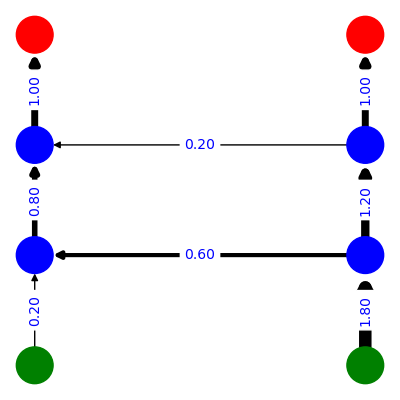

In [64]:

# Drawing the graph with customized edges
plt.figure(figsize=(4, 4))
DG = convert_to_directed2(G,"water_flux_heaton")
node_colors = ['red' if node in nodes_sink else 'green' if node in nodes_source else 'blue' for node in DG.nodes()]
edge_widths = [abs(flow) * 5 for flow in nx.get_edge_attributes(DG, 'water_flux_heaton').values()]

nx.draw(DG, pos=positions, with_labels=False, node_color=node_colors,width=edge_widths, node_size=700, font_size=15, font_color='darkred')
edge_labels = nx.get_edge_attributes(DG, 'water_flux_heaton')
edge_labels = {key : "{:.2f}".format(abs(edge_labels[key])) for key in edge_labels.keys()}
nx.draw_networkx_edge_labels(DG, pos=positions, edge_labels=edge_labels, font_color='blue')
plt.show()

In [65]:
for edge in G.edges:
    G[edge[0]][edge[1]]["radius"] = 3
    G[edge[0]][edge[1]]['v0'] = G[edge[0]][edge[1]]['water_flux_heaton']
DG = convert_to_directed(G)
for node in (nodes_source):
    DG.add_edge(node, "ground", length=0, radius=2, v0=0, Res=0, pot=0)  # Add edge back to the root

ext_flows = {}
A, b = build_matrix_system(DG, ext_flows)
flows = solve_flows(A, b)
edge_flows = {edge: flow for edge, flow in zip(DG.edges(), flows)}
nx.set_edge_attributes(G, edge_flows, "water_flux2")
for edge in G.edges:
    G[edge[0]][edge[1]]["water_flux2_abs"] = abs(G[edge[0]][edge[1]]["water_flux2"])

    G[edge[0]][edge[1]]["speed_backflow2"] = 2 * G[edge[0]][edge[1]]["water_flux2"] / (
                np.pi * G[edge[0]][edge[1]]["radius"] ** 2) - G[edge[0]][edge[1]]['v0']

found all cycles


Processing Cycles: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


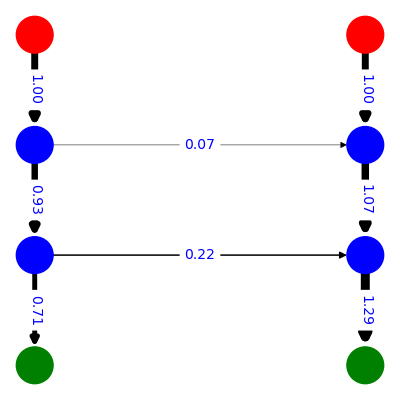

In [66]:

# Drawing the graph with customized edges
plt.figure(figsize=(4, 4))
DG = convert_to_directed2(G,"speed_backflow2")
node_colors = ['red' if node in nodes_sink else 'green' if node in nodes_source else 'blue' for node in DG.nodes()]
edge_widths = [abs(flow) * 5 for flow in nx.get_edge_attributes(DG, 'speed_backflow2').values()]

nx.draw(DG, pos=positions, with_labels=False, node_color=node_colors,width=edge_widths, node_size=700, font_size=15, font_color='darkred')
edge_labels = nx.get_edge_attributes(DG, 'speed_backflow2')
edge_labels = {key : "{:.2f}".format(abs(edge_labels[key])) for key in edge_labels.keys()}
nx.draw_networkx_edge_labels(DG, pos=positions, edge_labels=edge_labels, font_color='blue')
plt.show()